In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from statistics import median, mean
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load Recast Data

In [2]:
# Load models (axial and vector)
inputFiles = ['../CMS-EXO-20-004/scanResults_axial_reduced.pcl',
              '../CMS-EXO-20-004/scanResults_pseudoscalar_pt_nocut.pcl']

dfs = [pd.read_pickle(i) for i in inputFiles]
recastData = pd.concat(dfs, ignore_index=True)

### Get model points

In [3]:
models = []
mCols = ['Coupling', 'Mode', '$m_{med}$', '$m_{DM}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols, row.tolist()))
    if m not in models:
        models.append(m)

print('%i models loaded.' %len(models))

219 models loaded.


### Get model parameters

In [4]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': ['Axial', 'Pseudoscalar'], 'Mode': 'DM+QCDjets', '$m_{med}$': [10.0, 400.0, 295.0, 300.0, 3000.0, 2750.0, 2500.0, 200.0, 2250.0, 1995.0, 2000.0, 1750.0, 1500.0, 1250.0, 995.0, 100.0, 1000.0, 750.0, 500.0, 250.0], '$m_{DM}$': [800.0, 1.0, 100.0, 1400.0, 900.0, 200.0, 1000.0, 10.0, 300.0, 1100.0, 400.0, 1200.0, 500.0, 150.0, 600.0, 700.0]}
Coupling = ['Axial', 'Pseudoscalar']
Mode = DM+QCDjets


### Obtain limit on $\mu$ ratio

In [5]:
# Select year
recastData = recastData[recastData['Data-takingperiod'] == 2017]

In [6]:
# label = [c for c in recastData if (c.startswith("HCAL") and not "jets" in c)]

recastData = recastData[['Coupling', '$m_{med}$', '$m_{DM}$', 'Total xsec (pb)', '$\mu^{UL}_{obs}$']]

In [7]:
recastData['$\mu / \sigma$'] = recastData['$\mu^{UL}_{obs}$'] * recastData['Total xsec (pb)']

In [8]:
mCols = ['$m_{med}$','$m_{DM}$']
dataAx = recastData[recastData['Coupling'] == 'Axial']
dataVec = recastData[recastData['Coupling'] == 'Pseudoscalar']

In [9]:
keys = list(dataAx[mCols].columns.values)
i1 = dataAx.set_index(keys).index
i2 = dataVec.set_index(keys).index
dataAx = dataAx[i1.isin(i2)]
dataVec = dataVec[i2.isin(i1)]
# i3 = effPseudo.set_index(keys).index
print(len(dataAx),len(dataVec))

masspts = dataVec
masspts = masspts[['$m_{med}$', '$m_{DM}$']]

25 25


In [10]:
# Setting the index with mass pairs
dataAx = pd.DataFrame([dataAx.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in recastData if '$\mu / \sigma$' in c])
dataVec = pd.DataFrame([dataVec.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in recastData if '$\mu / \sigma$' in c])

In [11]:
ratio = []
for med, dm in dataAx:
    r = dataVec[med, dm] / dataAx[med, dm]
    ratio.append(r)

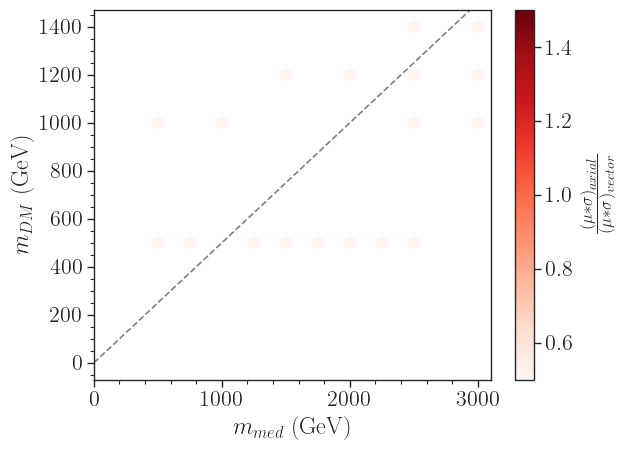

In [12]:
# Plot results
plt.scatter(x=masspts['$m_{med}$'], y=masspts['$m_{DM}$'], vmin=0.5, vmax=1.5,
            cmap=plt.cm.get_cmap('Reds'), c=ratio, s=60)

plt.axline((0, 0), slope=1/2, linestyle='--', color='gray')

cbar=plt.colorbar(label=r'$\frac{(\mu*\sigma)_{axial}}{(\mu*\sigma)_{vector}}$')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.minorticks_on()
# plt.ylim(0,1470)
plt.show()

In [13]:
pts = np.array([x for x in product(np.linspace(0.,3000.,100),np.linspace(0.,1400.,100))])
relDiffPts = griddata(list(zip(masspts['$m_{med}$'],masspts['$m_{DM}$'])),
                  np.array(ratio),pts)

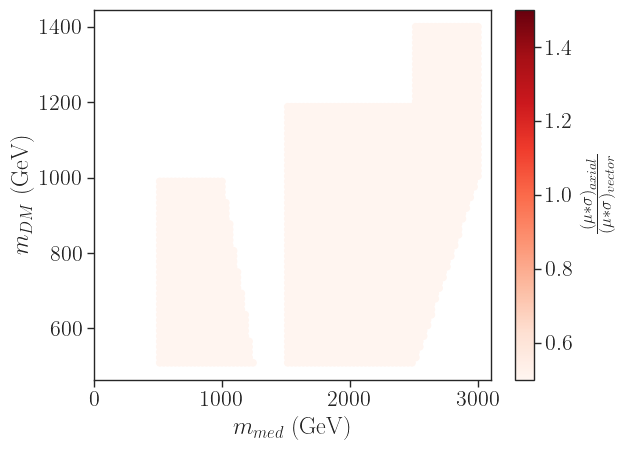

In [14]:
plt.scatter(x=pts[:,0], y=pts[:,1], vmin=0.5, vmax =1.5, 
            c=relDiffPts, cmap=plt.cm.get_cmap('Reds'))
cbar=plt.colorbar(label=r'$\frac{(\mu*\sigma)_{axial}}{(\mu*\sigma)_{vector}}$')
# plt.axline((1, 1), slope=1/2, linestyle='--', color='gray')

plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(0,1400)
plt.show()

In [15]:
ratio

[$\mu / \sigma$    0.459158
 Name: (500.0, 500.0), dtype: float64,
 $\mu / \sigma$    0.22262
 Name: (500.0, 1000.0), dtype: float64,
 $\mu / \sigma$   NaN
 Name: (500.0, 1200.0), dtype: float64,
 $\mu / \sigma$   NaN
 Name: (500.0, 1400.0), dtype: float64,
 $\mu / \sigma$    0.502435
 Name: (750.0, 500.0), dtype: float64,
 $\mu / \sigma$    0.217268
 Name: (1000.0, 1000.0), dtype: float64,
 $\mu / \sigma$   NaN
 Name: (1000.0, 1200.0), dtype: float64,
 $\mu / \sigma$   NaN
 Name: (1000.0, 1400.0), dtype: float64,
 $\mu / \sigma$    0.366675
 Name: (1250.0, 500.0), dtype: float64,
 $\mu / \sigma$   NaN
 Name: (1250.0, 1200.0), dtype: float64,
 $\mu / \sigma$    0.316967
 Name: (1500.0, 500.0), dtype: float64,
 $\mu / \sigma$    0.213149
 Name: (1500.0, 1200.0), dtype: float64,
 $\mu / \sigma$   NaN
 Name: (1500.0, 1400.0), dtype: float64,
 $\mu / \sigma$    0.323772
 Name: (1750.0, 500.0), dtype: float64,
 $\mu / \sigma$    0.349689
 Name: (2000.0, 500.0), dtype: float64,
 $\mu / \sigm

In [16]:
dataAx.T

$\mu / \sigma$
$m_{med}$ $m_{DM}$                
500.0     500.0           0.640369
          1000.0          0.394236
          1200.0          0.422683
          1400.0          0.336666
750.0     500.0           0.684344
1000.0    1000.0          0.395224
          1200.0          0.318503
          1400.0          0.395314
1250.0    500.0           0.884166
          1200.0          0.380693
1500.0    500.0           0.680957
          1200.0          0.382793
          1400.0          0.435748
1750.0    500.0           0.543186
2000.0    500.0           0.442961
          1200.0          0.382585
          1400.0          0.306934
2250.0    500.0           0.435639
2500.0    500.0           0.428555
          1000.0          0.414589
          1200.0          0.395469
          1400.0          0.407478
3000.0    1000.0          0.376334
          1200.0          0.370572
          1400.0          0.389591

In [18]:
dataVec.T

$\mu / \sigma$
$m_{med}$ $m_{DM}$                
500.0     500.0           0.294030
          1000.0          0.087765
          1200.0               NaN
          1400.0               NaN
750.0     500.0           0.343839
1000.0    1000.0          0.085869
          1200.0               NaN
          1400.0               NaN
1250.0    500.0           0.324201
          1200.0               NaN
1500.0    500.0           0.215841
          1200.0          0.081592
          1400.0               NaN
1750.0    500.0           0.175868
2000.0    500.0           0.154898
          1200.0          0.085727
          1400.0               NaN
2250.0    500.0           0.135164
2500.0    500.0           0.129654
          1000.0          0.098301
          1200.0          0.093733
          1400.0          0.074938
3000.0    1000.0          0.079010
          1200.0          0.079295
          1400.0          0.073794